### CNN Architectures
Creating complete CNN everytime can be a difficult task sometimes. Additionally we will have to check how good our architecture is performing while extracting featrures. To reduce this complexity pre-trained CNN architectures are used.
CNN architecuters examples:
1. ResNet
2. VGGNet
3. MobileNet
4. InceptionNet

There are different versions of all architectures based on the number of layers present in it. CNNs require very high computational power so all systems cannot suppport it that's why different architectures with different architecutures are available.




### Transfer learning
Transfer leraning is a method used for fine tuning pre-trainined architectures on new dataset. In this first a pre-trainined model is taken. In case of CNN most pretrainied models are trained on 'ImageNet'. ImageNet is a huge dataset containing more than more than 1.2 million images of total 1000 classes. Visit [here](http://www.image-net.org/) to get for more information about the dataset. After taking pre-trained model we directly train new dataset on it rather that training it from scratch. This process is called fine-tuning so we are trying to fine tune the pretrained model to out target dataset. The advantage of using pretrained models is that these architectures have been tested to extract many features like edges and curves. Therefore the overall speed of training process can be increased. 

### Downloading and storing data from kaggle
First get your own `kaggle.json` from your kaggle account and upload it to this file system

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alxmamaev/flowers-recognition

 97% 435M/450M [00:08<00:00, 54.8MB/s]
100% 450M/450M [00:08<00:00, 54.9MB/s]


In [0]:
!unzip -q flowers-recognition.zip

In [0]:
!rm -rf flowers/flowers

In [5]:
!pip install torch-lr-finder

### Importing and initializing global variables

In [6]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn import functional as F
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt
%matplotlib inline
import os

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
import warnings
warnings.simplefilter('ignore')

In [0]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Image data preprocessing

In [0]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize((0,), (0.50,)),
])

data = datasets.ImageFolder(root='flowers', transform=transform)

#### Create train test datasets
`torch.utils.data.random_split` function divides the input dataset based on the input sizes for the parts.

In [0]:
split_ratio = 0.8
data_len = len(data)
train_size = int(split_ratio * data_len)
test_size = data_len - train_size

# Randomly splits data into given sizes
train_dataset, test_dataset = random_split(data, lengths=(train_size, test_size))

In [0]:
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

We have to change the image input dimentions because pyplot expects input in 244 X 244 X 3 format and current input is in 3 X 244 X 244 format.

In [12]:
temp = train_dataset[3][0]
print('Before:', temp.size())
temp = temp.numpy().transpose([1, 2, 0])
print('After converting: ', temp.shape)

Before: torch.Size([3, 244, 244])
After converting:  (244, 244, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


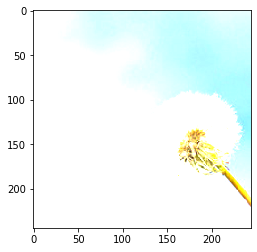

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


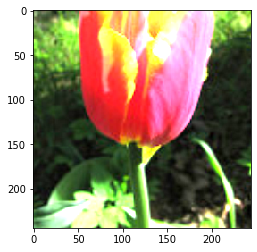

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


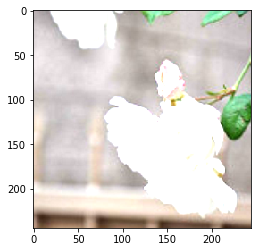

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


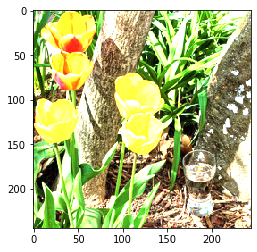

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


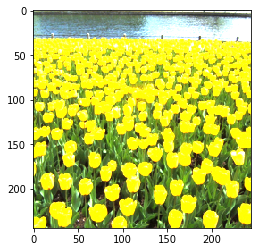

In [13]:
for i in range(0,5):
    temp = train_dataset[i][0]
    temp = temp.numpy().transpose([1, 2, 0])
    plt.imshow(temp)
    plt.show()

### Model requirements

#### Creating a model
`torchvision.models` contains CNN architectures pretrained on ImageNet. Whicle creating or extensing our model we will first import the complete architecture of the actual model in this case ResNet50. The output layers of ImageNet classifier contains 1000 classes for out classification problem we wiil add one output layer containing 5 nodes. We can also add more fully connected layer but for now we will add just one layer for simplicity.

In [0]:
class Model(torch.nn.Module):
    def __init__(self, num_classes=5, pretrained=False):
        super().__init__()
        self.upper_layers = models.resnet50(pretrained=pretrained)
        self.output_layer = torch.nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = F.relu(self.upper_layers(x))
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)

In [0]:
criterion = nn.NLLLoss()

####Training loop function

In [0]:
def train_model(model, num_epochs, model_save_name, optimizer):
    global criterion
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total =  0
        model.train()
        print(f'Epoch #{epoch + 1}')
        for input_batch, labels in trainloader:
            optimizer.zero_grad()
            output = model.forward(input_batch.to(device))
            loss = criterion(output, labels.to(device))
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            preds = torch.argmax(output, dim=1)
            correct += torch.sum(preds == labels.to(device)).item()
            total += labels.size(0)

        accuracy = correct / total
        print('Train accuracy: ', round(accuracy*100, 4), end='') 
        print(f' Loss: {epoch_loss/total}')
        test_accuracy(model, model_save_name)

#### Test accuracy function

In [0]:
def test_accuracy(model, path):
    global criterion
    test_lowest_loss = 0
    epoch_loss = 0
    correct = 0
    total =  0
    model.eval()
    with torch.no_grad():
        for input_batch, labels in testloader:
            output = model(input_batch.to(device))
            loss = criterion(output, labels.to(device))
            epoch_loss += loss.item()
            preds = torch.argmax(output, dim=1)

            correct += torch.sum(preds == labels.to(device)).item()
            total += labels.size(0)
            
        accuracy = correct / total
        print('test accuracy: ', round(accuracy*100, 4), end='')
        print(f'  Loss: {epoch_loss/total}')
        #saving the model with minimum loss for test
        if epoch_loss < test_lowest_loss:
            test_lowest_loss =  epoch_loss
            torch.save(model, path)

### Initiallizing the model object without pretrained weights

In [0]:
model_rsn_no_pre = Model(num_classes=5, pretrained=False)

#### Send model to GPU


In [48]:
model_rsn_no_pre.to(device)

Model(
  (upper_layers): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [0]:
optimizer = torch.optim.Adam(model_rsn_no_pre.parameters(), lr=1e-3)

#### Call model train without pretrained weights

In [50]:
train_model(model_rsn_no_pre, num_epochs=35, model_save_name='no_transfer_no_aug.pth', optimizer=optimizer)

Epoch #1
Train accuracy:  37.6518 Loss: 0.09357821544930726
test accuracy:  47.052  Loss: 0.07934977677516165
Epoch #2
Train accuracy:  52.3713 Loss: 0.07363760576488104
test accuracy:  55.7225  Loss: 0.07217679857518632
Epoch #3
Train accuracy:  57.7791 Loss: 0.06675383791611883
test accuracy:  57.341  Loss: 0.07509496149989221
Epoch #4
Train accuracy:  62.3193 Loss: 0.06187264715198012
test accuracy:  51.4451  Loss: 0.10490450611004251
Epoch #5
Train accuracy:  63.4182 Loss: 0.05989722505927155
test accuracy:  58.4971  Loss: 0.07105408045597848
Epoch #6
Train accuracy:  64.8641 Loss: 0.05792652943563158
test accuracy:  62.7746  Loss: 0.059919472788110634
Epoch #7
Train accuracy:  65.587 Loss: 0.056803990161922224
test accuracy:  56.763  Loss: 0.07344511078961323
Epoch #8
Train accuracy:  66.7149 Loss: 0.054627144738316466
test accuracy:  61.0405  Loss: 0.05985476267820149
Epoch #9
Train accuracy:  67.3222 Loss: 0.05358910801060424
test accuracy:  67.8613  Loss: 0.053736620038920054
E

### Initiallizing the model object with pretrained weights

In [0]:
model_rsn_with_pre = Model(num_classes=5, pretrained=True)

#### Send model to GPU

In [52]:
model_rsn_with_pre.to(device)

Model(
  (upper_layers): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

#### Freezing first CNN layers
In transfer learning we already have a pretrained CNN which is fairly good at extracting features. So initially while training our model we don't want to change CNN part. So we freez CNN layers and just train the added fully connected layers at the end. If we freez layers then weights corresponding to these layers won't update while training. We can define the layers which we want to train in `optimizer`. In this example first we are training just last 2 added layers.

In [0]:
optimizer = torch.optim.Adam(
            [
                {"params": model_rsn_with_pre.upper_layers.fc.parameters(), "lr": 1e-3},
                {"params": model_rsn_with_pre.output_layer.parameters(), "lr": 1e-3}
            ],
        )

### Call model train with pretrained weights

In [54]:
train_model(model_rsn_with_pre, num_epochs=5, model_save_name='transfer_no_aug.pth',optimizer=optimizer)

Epoch #1
Train accuracy:  77.3858 Loss: 0.04051276783745988
test accuracy:  87.2832  Loss: 0.025805581804644855
Epoch #2
Train accuracy:  84.1816 Loss: 0.026688902408849854
test accuracy:  82.7746  Loss: 0.02941343424292658
Epoch #3
Train accuracy:  87.0735 Loss: 0.02274580741330266
test accuracy:  89.0173  Loss: 0.020612711162236383
Epoch #4
Train accuracy:  87.247 Loss: 0.02210854609028806
test accuracy:  89.9422  Loss: 0.018429978079878527
Epoch #5
Train accuracy:  88.1434 Loss: 0.020354700752546362
test accuracy:  89.5954  Loss: 0.02031277747168017


#### Fine tuning
After training last layers only we want to unfreez the complete model and fine tune it for out dataset. So we will unfreez all layers and train the complete model with a lower learning rate. The learning rate is low because we don't want to change the model too much by taking big steps.

#### Gradual unfreezing
In case of gradual unfreezing we first unfreez some last layers then train for a few epoch and then keep unfreezing some layers and at the end unfreez the complete model. As we keep unfreezing gradually we also keep reducing the learning rate. The initial layers of CNN can extract base features efficiently so we don't want to change their weights too much so we gradually keep reducing the learning rate as we keep unfreezing the layers from the last.

In [0]:
optimizer = torch.optim.Adam(model_rsn_with_pre.parameters(), lr=5e-6)

In [56]:
train_model(model_rsn_with_pre, num_epochs=10, model_save_name='transfer_no_aug.pth',optimizer=optimizer)

Epoch #1
Train accuracy:  93.8693 Loss: 0.011670916350402192
test accuracy:  91.2139  Loss: 0.015889603252700297
Epoch #2
Train accuracy:  96.5876 Loss: 0.007287114594689748
test accuracy:  90.9827  Loss: 0.020373238605915465
Epoch #3
Train accuracy:  97.7444 Loss: 0.0051617532550530185
test accuracy:  91.5607  Loss: 0.015598953493757743
Epoch #4
Train accuracy:  98.5541 Loss: 0.0038526297119775214
test accuracy:  91.9075  Loss: 0.017438062603418538
Epoch #5
Train accuracy:  98.9589 Loss: 0.003011293655413296
test accuracy:  92.0231  Loss: 0.017057705558621124
Epoch #6
Train accuracy:  99.2481 Loss: 0.002634758311778979
test accuracy:  91.3295  Loss: 0.01672300254506183
Epoch #7
Train accuracy:  99.4795 Loss: 0.0018764476406567354
test accuracy:  92.6012  Loss: 0.01642625221627296
Epoch #8
Train accuracy:  99.5084 Loss: 0.001970455209908284
test accuracy:  92.7168  Loss: 0.01693569252945784
Epoch #9
Train accuracy:  99.7976 Loss: 0.0010023622015709818
test accuracy:  92.6012  Loss: 0.0

In [0]:
optimizer = torch.optim.Adam(model_rsn_with_pre.parameters(), lr=1e-6)

In the next training as the total testing loss has started increasing it means that the model is overfitting to the training dataset.

In [58]:
train_model(model_rsn_with_pre, num_epochs=10, model_save_name='transfer_no_aug.pth',optimizer=optimizer)

Epoch #1
Train accuracy:  99.7687 Loss: 0.0011788936910376237
test accuracy:  92.7168  Loss: 0.016070442048111405
Epoch #2
Train accuracy:  99.7397 Loss: 0.001281556459504652
test accuracy:  92.6012  Loss: 0.017290677810679972
Epoch #3
Train accuracy:  99.6241 Loss: 0.0013253053358312698
test accuracy:  92.0231  Loss: 0.017128675073557507
Epoch #4
Train accuracy:  99.7976 Loss: 0.0007547310011072473
test accuracy:  92.7168  Loss: 0.017112081006944523
Epoch #5
Train accuracy:  99.7687 Loss: 0.0014451285851112055
test accuracy:  92.6012  Loss: 0.017001878250541027
Epoch #6
Train accuracy:  99.8843 Loss: 0.00133632043965846
test accuracy:  92.0231  Loss: 0.01740362149787087
Epoch #7
Train accuracy:  99.9132 Loss: 0.0005381332571414111
test accuracy:  91.9075  Loss: 0.01745338449416133
Epoch #8
Train accuracy:  99.8554 Loss: 0.000659703094449741
test accuracy:  92.4855  Loss: 0.01785279514989412
Epoch #9
Train accuracy:  99.9132 Loss: 0.000663763382932642
test accuracy:  92.0231  Loss: 0.0

### Model with data augmentation

If available data is not enough to extract relevant patterns and features data augmentation techniques are used. Data augmentation is normally applied on the training data to increase the total amount of data available for training. In case of image data we take an original image from the dataset and apply operations like image rotation at some angle, flipping image or changing the brightness of the image and add these augmented image to the training dataset with the same label as the original image.<br><br>

In Pytorch `transforms` are noramlly applied while creating the dataset. But we are not going to apply data augmentation on the testing dataset. So we will have to apply transform again after splitting data into trainig and testing. For that, following code can apply transform after creating the train and test datasets.

In [0]:
class ApplyTransform(Dataset):
    """
    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

While reading files we can apply common transforamtions like Resizing the image and Cropping the required part. 

In [0]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(244),
])

data = datasets.ImageFolder(root='flowers', transform=transform)

In [61]:
split_ratio = 0.8
data_len = len(data)
train_size = int(split_ratio * data_len)
test_size = data_len - train_size

# Randomly splits data into given sizes
train_dataset, test_dataset = random_split(data, lengths=(train_size, test_size))
print(len(train_dataset))

3458


After train test split, apply roatationa flip operations. At the end convert it to Tensor and then apply Normalization. We cannot normalize before converting to Tensor so keep the order of operation in mind while applying `transforms`.

In [0]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0,), (0.50,))

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
        transforms.Normalize((0,), (0.50,))
])

train_dataset = ApplyTransform(train_dataset, transform=transform_train)
test_dataset = ApplyTransform(test_dataset, transform=transform_test)

In [0]:
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [0]:
temp = train_dataset[3][0]
temp = temp.numpy().transpose([1, 2, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


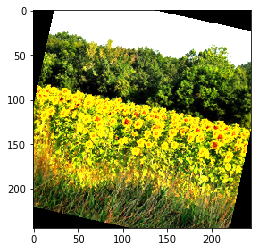

In [65]:
plt.imshow(temp)

In [0]:
model_rsn_with_pre_with_aug = Model(num_classes=5, pretrained=True)

In [67]:
model_rsn_with_pre_with_aug.to(device)

Model(
  (upper_layers): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [0]:
optimizer = torch.optim.Adam(
            [
                {"params": model_rsn_with_pre_with_aug.upper_layers.fc.parameters(), "lr": 1e-3},
                {"params": model_rsn_with_pre_with_aug.output_layer.parameters(), "lr": 1e-3}
            ],
        )

In [69]:
train_model(model_rsn_with_pre_with_aug, num_epochs=5, model_save_name='transfer_aug.pth',optimizer=optimizer)

Epoch #1
Train accuracy:  72.2094 Loss: 0.04755518225842022
test accuracy:  83.1214  Loss: 0.026582847303048725
Epoch #2
Train accuracy:  81.2608 Loss: 0.032058067328930594
test accuracy:  83.815  Loss: 0.026609209558867305
Epoch #3
Train accuracy:  83.3141 Loss: 0.029457723151972145
test accuracy:  86.9364  Loss: 0.024335179292742228
Epoch #4
Train accuracy:  83.7767 Loss: 0.02755181628837966
test accuracy:  85.3179  Loss: 0.02531538998460494
Epoch #5
Train accuracy:  85.0781 Loss: 0.02532460300726929
test accuracy:  87.052  Loss: 0.021770770287927177


In [0]:
optimizer = torch.optim.Adam(model_rsn_with_pre_with_aug.parameters(), lr=5e-6)

In [71]:
train_model(model_rsn_with_pre_with_aug, num_epochs=10, model_save_name='transfer_no_aug.pth',optimizer=optimizer)

Epoch #1
Train accuracy:  89.0688 Loss: 0.019187903963568034
test accuracy:  89.3642  Loss: 0.01866322019368927
Epoch #2
Train accuracy:  91.8739 Loss: 0.015418519959189837
test accuracy:  90.4046  Loss: 0.016636391139099364
Epoch #3
Train accuracy:  92.8282 Loss: 0.012862006642954277
test accuracy:  90.4046  Loss: 0.01642796182735807
Epoch #4
Train accuracy:  94.5344 Loss: 0.010706965139856429
test accuracy:  90.289  Loss: 0.015992426794732926
Epoch #5
Train accuracy:  94.2741 Loss: 0.010792027697820344
test accuracy:  91.2139  Loss: 0.015384581340530704
Epoch #6
Train accuracy:  96.1538 Loss: 0.007748285555181095
test accuracy:  92.0231  Loss: 0.020233450554354344
Epoch #7
Train accuracy:  96.0671 Loss: 0.008126368551170847
test accuracy:  92.1387  Loss: 0.015414453922324097
Epoch #8
Train accuracy:  96.3274 Loss: 0.00729776189558557
test accuracy:  91.6763  Loss: 0.01577026415077937
Epoch #9
Train accuracy:  97.2817 Loss: 0.0055857447636927255
test accuracy:  92.6012  Loss: 0.015031

In [0]:
optimizer = torch.optim.Adam(model_rsn_with_pre_with_aug.parameters(), lr=1e-6)

In [73]:
train_model(model_rsn_with_pre_with_aug, num_epochs=10, model_save_name='transfer_no_aug.pth',optimizer=optimizer)

Epoch #1
Train accuracy:  97.7444 Loss: 0.0049328549181694515
test accuracy:  92.3699  Loss: 0.015076137097240183
Epoch #2
Train accuracy:  97.889 Loss: 0.004629297816491389
test accuracy:  92.7168  Loss: 0.014894836245244639
Epoch #3
Train accuracy:  97.9757 Loss: 0.004548999874654914
test accuracy:  93.0636  Loss: 0.02081918555360309
Epoch #4
Train accuracy:  97.9468 Loss: 0.004131898349673504
test accuracy:  93.0636  Loss: 0.015404606365055019
Epoch #5
Train accuracy:  98.4384 Loss: 0.0036099856119320667
test accuracy:  93.1792  Loss: 0.01462389019700144
Epoch #6
Train accuracy:  98.5541 Loss: 0.004288215988448688
test accuracy:  91.9075  Loss: 0.0152626592816645
Epoch #7
Train accuracy:  98.583 Loss: 0.0032769635593343015
test accuracy:  92.0231  Loss: 0.015152203829991336
Epoch #8
Train accuracy:  98.3516 Loss: 0.0035098603414344676
test accuracy:  92.2543  Loss: 0.014796106680969283
Epoch #9
Train accuracy:  98.4384 Loss: 0.003917461285931034
test accuracy:  92.3699  Loss: 0.0150